# Analysis of Variation Types in Feature Spaces

## 1. Comparison of Performance of a Traditional Learner in Different Variation Patterns
We try to observe any recurring pattern in terms of performance when variation pattern differs.

In [3]:
import model
import dataloader as dl
import numpy as np
import trainer
import parameters as p
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import torch


datasets = ['german', 'ionosphere', 'spambase', 'magic04', 'a8a']
model_type = 'hinge_oco'#'jeev_backprop'

torch.manual_seed(p.random_state)
np.random.seed(p.random_state)



# initialize results dict
results = {}
masks = {}
occurrences = {}

for dataset in datasets:
    results[dataset] = {}
    masks[dataset] = {}
    occurrences[dataset] = {}
    for scenario in p.scenarios:
        results[dataset][scenario] = 0
        masks[dataset][scenario] = []

for scenario in p.scenarios:
    for dataset_name in datasets:
        Xpath, ypath = dl.get_path(dataset_name)
        X, y = dl.read_dataset(Xpath, ypath)
        num_features = len(X[0])
        m = p.models[model_type](num_features, p.learning_rate)
        fold_errors, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario])
        masks[dataset_name][scenario] = fold_masks
        results[dataset_name][scenario] = np.mean(fold_errors)
        print(dataset_name, scenario, model_type, np.mean(fold_errors))
    print()    
    
    
# plot results for each dataset
for dataset_name in datasets:
    plt.title(dataset_name)
    plt.ylabel('Error Rate')
    plt.bar(results[dataset_name].keys(), results[dataset_name].values())
    plt.show()

german varying_gaussian hinge_oco 0.5034
ionosphere varying_gaussian hinge_oco 0.5289999999999999
spambase varying_gaussian hinge_oco 0.4931521739130435
magic04 varying_gaussian hinge_oco 0.48996003996003995
a8a varying_gaussian hinge_oco 0.43585433556573844

german varying_uniform hinge_oco 0.30195
ionosphere varying_uniform hinge_oco 0.364
spambase varying_uniform hinge_oco 0.30206521739130443


KeyboardInterrupt: 

In [ ]:
for key in masks:
    for scenario in p.scenarios:
        sum_masks = copy.deepcopy(masks[key][scenario][0])
        for i in range(1, len(masks[key][scenario])):
            sum_masks += masks[key][scenario][i]

        avg_sum_masks =  sum_masks / len(masks[key][scenario])
        avg_sum_masks = np.sum(avg_sum_masks, axis=0) / len(sum_masks)
        occurrences[key][scenario] = avg_sum_masks
        
        plt.title(key + scenario)
        plt.plot(occurrences[key][scenario])
        plt.show()

**We have made two observations so far:**
1. Performance in non-uniformly distributed variation in feature spaces is worse than uniform.
2. Checking the average availability frequency of features don't immediately give an explanation about this.

After this, Jeev suggested to look at the co-occurrences of features.

## Performance vs. Feature Co-Occurrence Patterns
Let us take the *german* dataset and see how feature co-occurrences look like in different versions of the variation.
To do this, we first merge the masks from different folds of cross-validation we have.
Masks represent the feature availability in a training instance, therefore, useful when we are working on structures of feature spaces.


In [ ]:
def show_cov_mat(masks, dataset, setting):
    m = masks[dataset][setting]
    joint_mask = m[0]
    
    for i in range(1, len(m)):
        joint_mask = np.vstack((joint_mask, m[i]))
    
    cov_mat = np.cov(joint_mask.T)
    sns.heatmap(cov_mat)
    plt.show()
    return cov_mat


settings = ['full', 'varying_uniform', 'varying_gaussian']

for dataset in datasets:
    for setting in settings:
        print(dataset)
        show_cov_mat(masks, dataset, setting)

We see that an important is that varying feature spaces distribution in a uniform fashion have low covariance -> feature co-occurrence. This means feature occurrences don't follow a particular pattern. On the other hand, for gaussian, there exists various amounts of covariance between features, starting to form a pattern. This seems to be making learning harder for some reason.

**Note:** In both cases, the diagonal of the matrix seems to be 0.25. Diagonals of a covariance matrix are the variances of the components of the vector.

## Relationship Between the Amount of Covariance in Varying Gaussian and the Traditional Model Performance
In this section, we take the generator of varying_gaussian and modify it in a way that it removes features in different levels of variation.

In [ ]:
variations = [0, 0.25, 0.5, 0.75]
for variation in variations:
    p.cov_strength = variation
    print("Cov Strength: %f" % variation)
# initialize results dict
    results = {}
    masks = {}
    occurrences = {}

    for dataset in datasets:
        results[dataset] = {}
        masks[dataset] = {}
        occurrences[dataset] = {}
        for scenario in p.scenarios:
            results[dataset][scenario] = 0
            masks[dataset][scenario] = []

    for scenario in ['varying_gaussian']:
        for dataset_name in p.datasets:
            Xpath, ypath = dl.get_path(dataset_name)
            X, y = dl.read_dataset(Xpath, ypath)
            num_features = len(X[0])
            m = p.models[model_type](num_features, p.learning_rate)
            fold_errors, fold_losses, fold_weights, fold_masks = trainer.cross_validation(X, y, m, p.folds, p.scenarios[scenario])
            masks[dataset_name][scenario] = fold_masks
            print('Total features received: %f' % np.sum(fold_masks))
            print('Avg. features per instance: %f' % (np.sum(fold_masks) / p.folds / len(fold_masks[0])))
            results[dataset_name][scenario] = np.mean(fold_errors)
            print(dataset_name, scenario, model_type, np.mean(fold_errors))
            print()
        print()
        print()

# Additional Observations
1. Jeev's backprop version performs better than mine for some reason -> understand why.
2. Jeev's backprop version's performance degrades if local biases are removed.
3. Performance won't change too much if the trainable weights in between the layers are removed.
4. Performance won't change if weights are initialized to 0 instead of Xavier.

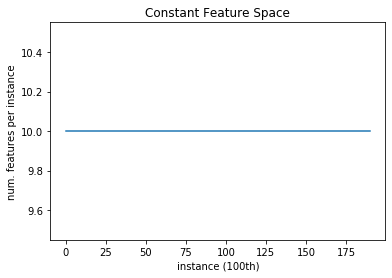

In [25]:
plt.xlabel('instance (100th)')
plt.ylabel('num. features per instance')
plt.title('Constant Feature Space')
plt.plot(np.sum(masks['magic04']['full'][0], axis=1)[::100])

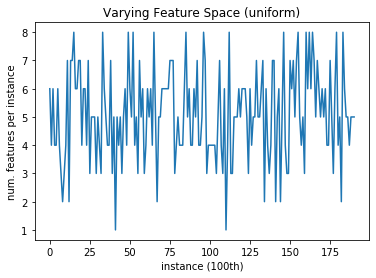

In [28]:
plt.xlabel('instance (100th)')
plt.ylabel('num. features per instance')
plt.title('Varying Feature Space (uniform)')
plt.plot(np.sum(masks['magic04']['varying_uniform'][0], axis=1)[::100])

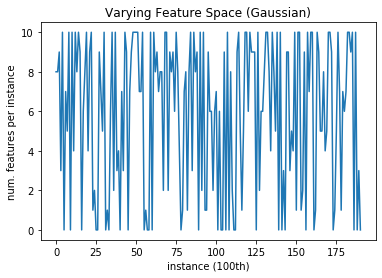

In [4]:
plt.xlabel('instance (100th)')
plt.ylabel('num. features per instance')
plt.title('Varying Feature Space (Gaussian)')
plt.plot(np.sum(masks['magic04']['varying_gaussian'][0], axis=1)[::100])

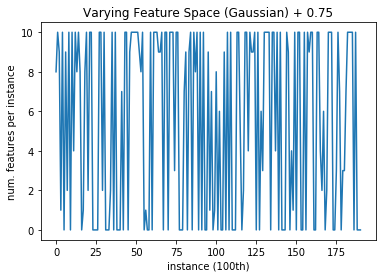

In [4]:
plt.xlabel('instance (100th)')
plt.ylabel('num. features per instance')
plt.title('Varying Feature Space (Gaussian) + 0.75')
plt.plot(np.sum(masks['magic04']['varying_gaussian'][0], axis=1)[::100])

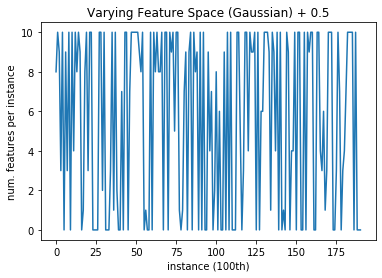

In [2]:
plt.xlabel('instance (100th)')
plt.ylabel('num. features per instance')
plt.title('Varying Feature Space (Gaussian) + 0.5')
plt.plot(np.sum(masks['magic04']['varying_gaussian'][0], axis=1)[::100])

In [2]:
cov_mat = np.cov(masks['magic04']['varying_gaussian'][0].T)

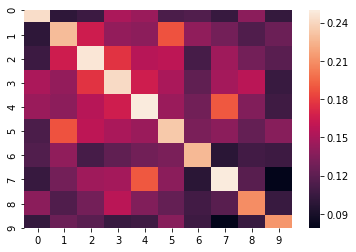

In [3]:
sns.heatmap(cov_mat)

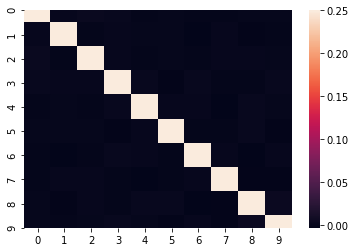

In [5]:
cov_mat_uni = np.cov(masks['magic04']['varying_uniform'][0].T)
sns.heatmap(cov_mat_uni)

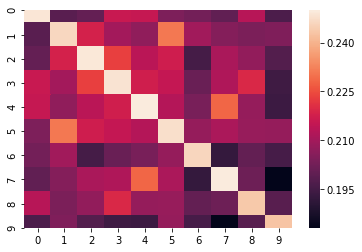

In [2]:
cov_mat = np.cov(masks['magic04']['varying_gaussian'][0].T)
sns.heatmap(cov_mat)